# 1. CIFAR-10 dataset에 대한 이미지 분류를 Keras를 사용한 CNN(Convolution Neural Network)으로 구현

사람이 눈으로 사물을 보고 무엇인지 인지하거나 장면을 이해하듯이, 컴퓨터로 하여금 사진 또는 동영상으로부터 특정 객체의 위치와 자세를 찾아내거나 장면을 인식하도록 만드는 작업이 필요합니다. 사람은 사진 속의 사물을 매우 빠르고 정확하게, 그리고 직관적으로 이해할 수 있습니다. 그러나 컴퓨터가 사람처럼 사진을 인식하고 사물을 빠르고 정확하게 찾을 수 있게 만드는 것은 결코 쉽지 않습니다. 이를 딥러닝의 신경망 구조로 처리하고자 고안된 것이 합성곱 신경망(CNN; Convolutional Neural Network) 입니다.

왜 합성곱 신경망은 이미지를 처리하는 데에 효과적일까요? 입력층과 출력층의 뉴런이 전부 연결된 Fully connected layer(Dense layer)는 1차원 데이터의 처리에만 한정적입니다. 하지만 이미지의 텐서는(samples, height, width, channel) 크기의 4D 텐서(3차원)로, 이를 1차원으로 변형시키면 데이터의 형상이 소실되는 단점이 있습니다. 수학에서의 합성곱 개념을 사용하면 3차원 데이터의 공간적인 정보를 유지한 채 다음 레이어로 보낼 수 있기 때문에, 이미지 인식에 있어 특히 CNN을 사용합니다.

 
합성공 신경망(CNN)은 비전 분야에 다음과 같이 활용될 수 있습니다.
* 영상에서 물체의 인식, 분할
* 같은 장면이나 물체에 대한 다른 뷰의 등록
* 연속 영상에서 물체를 추적
* 어떤 장면을 3차원 모델로 매핑
* 인간의 자세와 팔다리 움직임을 3차원으로 추정


## 합성공 신경망(CNN) 기본 구조
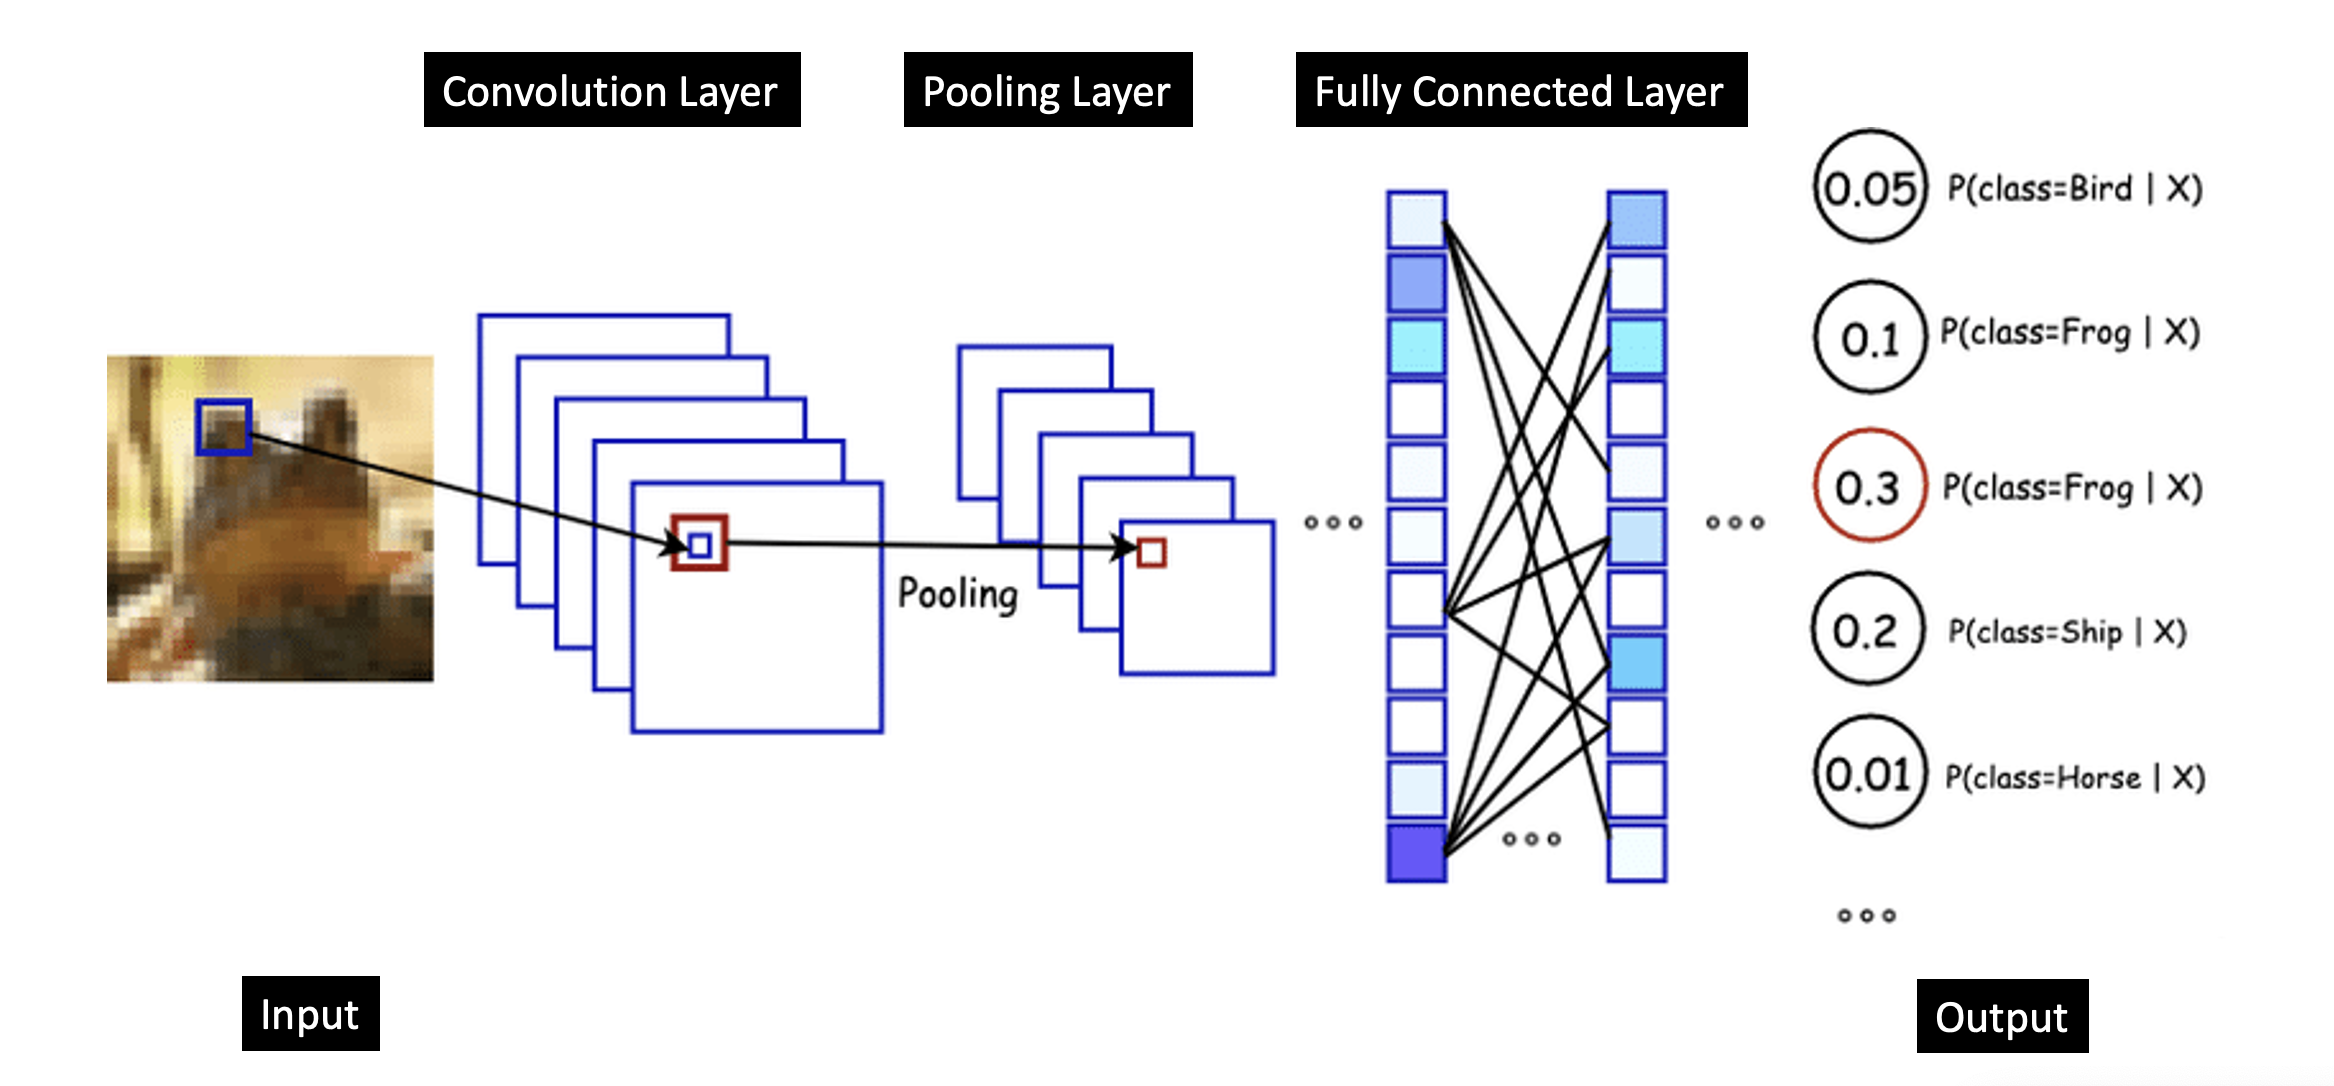

기존 신경망 구조에 합성곱 계층과 풀링 계층을 Fully connected 계층 이전에 추가하여 원본 이미지에 필터링 기법을 적용할 수 있다.

Keras를 기반으로 CIFAR 이미지셋을 이용하여 합성곱 신경망(CNN) 모델을 구축하여 이미지를 분류하는 예제를 소개합니다.

## 1.1 준비

필요한 라이브러리들을 import 합니다.

In [2]:
import tensorflow.keras as keras
import keras.utils
import sagemaker

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from sagemaker.tensorflow import TensorFlowModel

import matplotlib.pyplot as plt
import numpy as np
import tarfile

2024-02-23 04:54:39.353191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# SageMaker 역할 정보, S3 버킷 정보
role = sagemaker.get_execution_role()
sm_session = sagemaker.Session()
bucket_name = sm_session.default_bucket()

## 1.2 사용할 데이터셋 확인

CIFAR 10은 32x32사이즈의 RGB 이미지 데이터셋으로, 10가지의 레이블이 붙어있습니다. 작은 이미지지만, 10개의 레이블로 예측해보는 연습을 할 수 있습니다.

170498071/170498071 [==============================] - 5s 0us/step


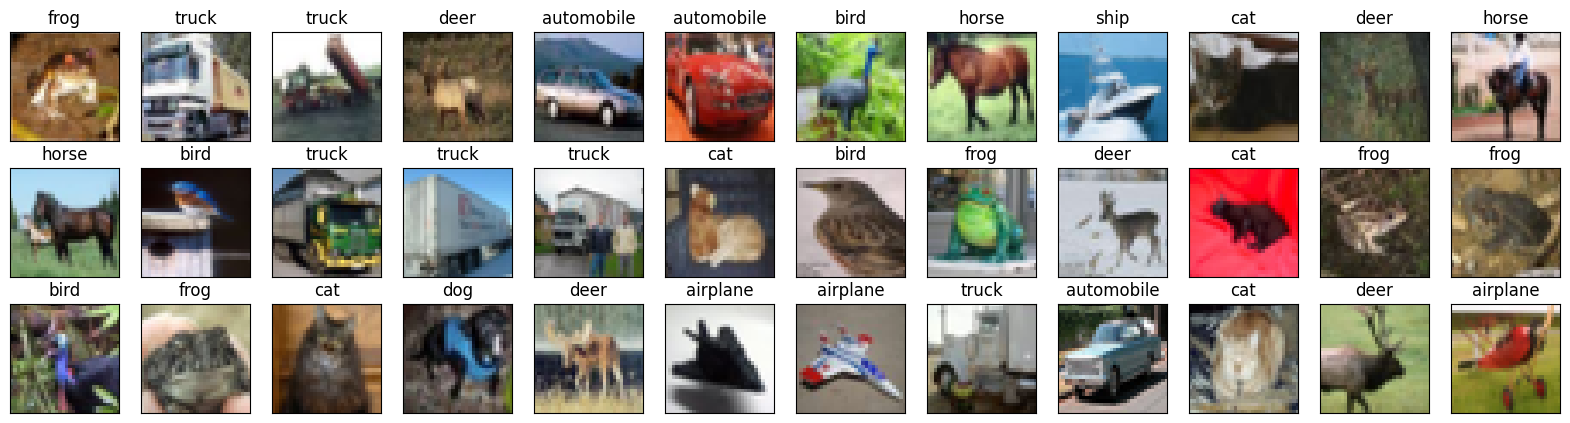

In [4]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(20,5))

for i in range(36):
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(train_images[i])
    idx = int(train_labels[i])
    ax.set_title(label[idx])

## 1.3. 데이터 전처리

In [5]:
train_images = train_images / 255.0
test_images = test_images / 255.0

train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

## 1.4 CNN 모델 구성
Sequential 클래스를 사용해서 인공신경망의 각 층을 순서대로 쌓을 수 있습니다. add() 메서드를 이용해서 합성곱층 Conv2D와 Max pooling층 MaxPooling2D를 반복해서 구성합니다.


* 합성곱 연산에서 사용되는 필터(filter)는 이미지에서 특징(feature)을 분리해내는 기능을 합니다.  
    * filters의 값은 합성곱에 사용되는 필터의 종류(개수)이며, 출력 공간의 차원(깊이)을 결정합니다.  
    * kernel_size는 합성곱에 사용되는 필터(=커널)의 크기입니다.  
    * strides는 풀링 필터를 이동시키는 간격을 의미합니다.  
    * 활성화 함수(activation function)는 ‘relu’로 지정하고,  
    * 입력 데이터의 형태(input_shape)는 이미지 하나의 형태에 해당하는 (32, 32, 3)으로 설정합니다.  


* 풀링(Pooling)은 합성곱에 의해 얻어진 Feature map으로부터 값을 샘플링해서 정보를 압축하는 과정을 의미합니다.  
    * Max-pooling은 특정 영역에서 가장 큰 값을 샘플링하는 풀링 방식이며, 풀링 필터의 크기를 2×2 영역으로 설정했습니다.  


* 합성곱층에 이어 분류를 담당하는 Dense층(Fully-connected layer)을 추가합니다.

In [6]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=4, padding='same', strides=1, activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=4, padding='same', strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=4, padding='same', strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

# CNN에 대한 정보 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          65600     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 64)          0

2024-02-23 04:54:57.034575: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## 1.5 모델 컴파일

compile() 메서드를 이용해서 옵티마이저, 손실 함수, 지표를 각각 설정해줍니다.

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 1.6 모델 훈련

fit() 메서드에 미리 준비한 데이터를 이용하여 10번의 훈련을 진행합니다.

In [8]:
hist = model.fit(train_images, train_labels, batch_size=128, epochs=10, verbose=1, validation_data=(test_images, test_labels))

Epoch 1/10
391/391 [==============================] - 46s 116ms/step - loss: 1.5448 - accuracy: 0.4362 - val_loss: 1.2236 - val_accuracy: 0.5707
Epoch 2/10
391/391 [==============================] - 45s 115ms/step - loss: 1.1073 - accuracy: 0.6072 - val_loss: 1.0277 - val_accuracy: 0.6390
Epoch 3/10
391/391 [==============================] - 45s 115ms/step - loss: 0.9192 - accuracy: 0.6751 - val_loss: 0.9154 - val_accuracy: 0.6821
Epoch 4/10
391/391 [==============================] - 45s 116ms/step - loss: 0.7894 - accuracy: 0.7230 - val_loss: 0.8812 - val_accuracy: 0.6952
Epoch 5/10
391/391 [==============================] - 45s 115ms/step - loss: 0.6964 - accuracy: 0.7562 - val_loss: 0.7830 - val_accuracy: 0.7304
Epoch 6/10
391/391 [==============================] - 47s 121ms/step - loss: 0.6144 - accuracy: 0.7854 - val_loss: 0.7991 - val_accuracy: 0.7271
Epoch 7/10
391/391 [==============================] - 45s 115ms/step - loss: 0.5408 - accuracy: 0.8116 - val_loss: 0.7815 - val_ac

## 1.7 모델 평가
모델의 정확도를 평가하여 그래프로 표시합니다.

313/313 [==============================] - 3s 10ms/step - loss: 0.8940 - accuracy: 0.7430


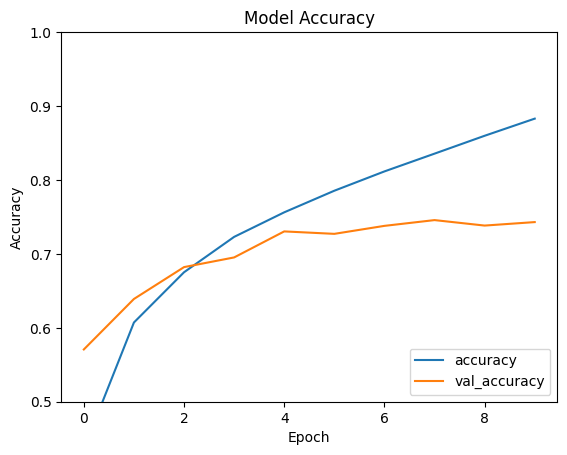

In [9]:
loss, acc = model.evaluate(test_images, test_labels)

plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## 1.8 훈련된 모델을 통해 이미지 분류 예측

In [10]:
pred = model.predict(test_images)

313/313 [==============================] - 3s 10ms/step


1/1 [==============================] - 0s 18ms/step


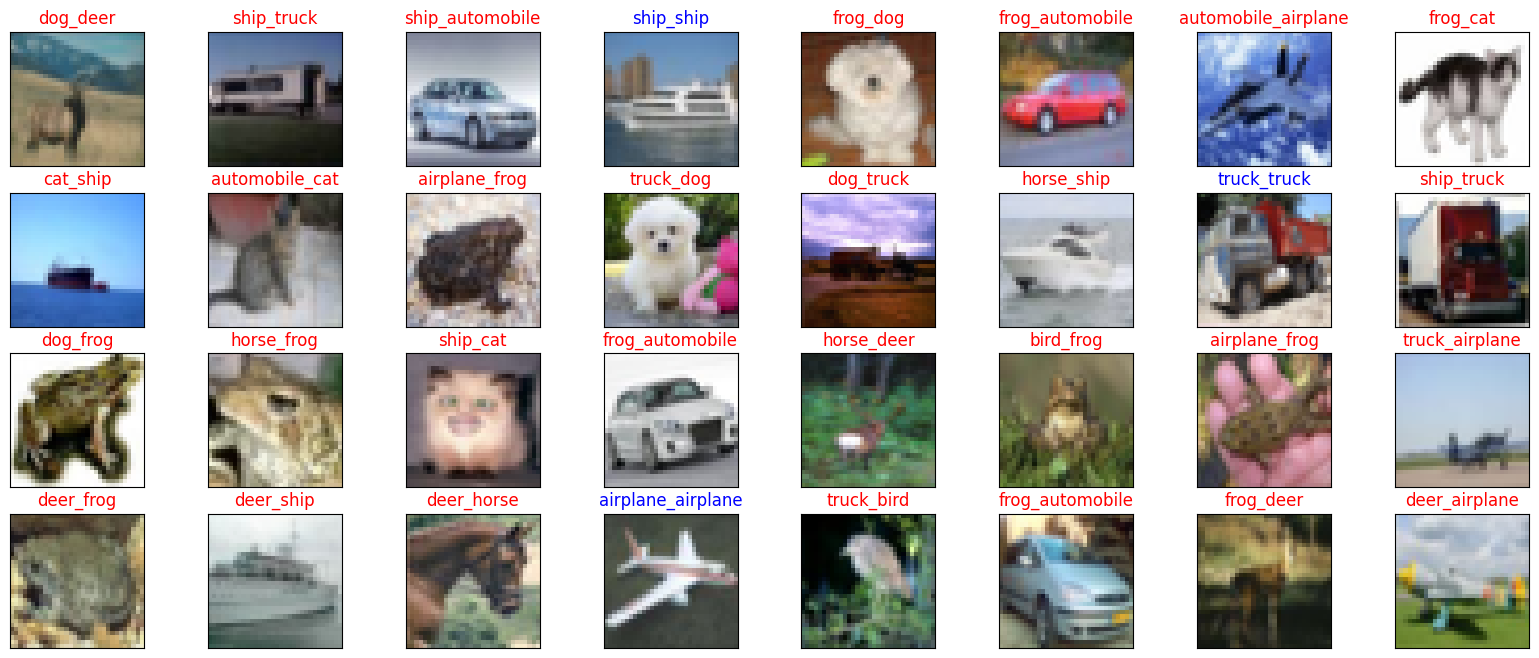

In [11]:
import numpy as np

label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(20,8))

for i, idx in enumerate(np.random.choice(test_images.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4,8, i+1 , xticks=[], yticks=[])
    
    
    # 훈련된 모델 사용 
    output = model.predict(test_images[i].reshape(1, 32, 32, 3))
    
    pred_idx = np.argmax(output)
    true_idx = np.argmax(test_labels[idx])
    
    ax.imshow(np.squeeze(test_images[idx]))
    
    # 이미지 출력 - 예측한 결과가 정답이면 파란색, 아니면 빨간색으로 표시
    ax.set_title("{}_{}".format(label[pred_idx], label[true_idx]), color='blue' if pred_idx == true_idx else 'red')

## 1.9 모델 저장

In [12]:
# 모델 저장
model.save("export/Servo/1")

with tarfile.open("model.tar.gz", "w:gz") as tar:
    tar.add("export")

INFO:tensorflow:Assets written to: export/Servo/1/assets


INFO:tensorflow:Assets written to: export/Servo/1/assets


In [13]:
# 모델을 S3에 업로드
s3_response = sm_session.upload_data("model.tar.gz", bucket=bucket_name, key_prefix="model")

In [14]:
# 모델 생성
sagemaker_model = TensorFlowModel(
    model_data=f"s3://{bucket_name}/model/model.tar.gz",
    role=role,
    framework_version="2.3",
)

## 1.10 모델 배포

In [15]:
# 모델 배포
predictor = sagemaker_model.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

---!

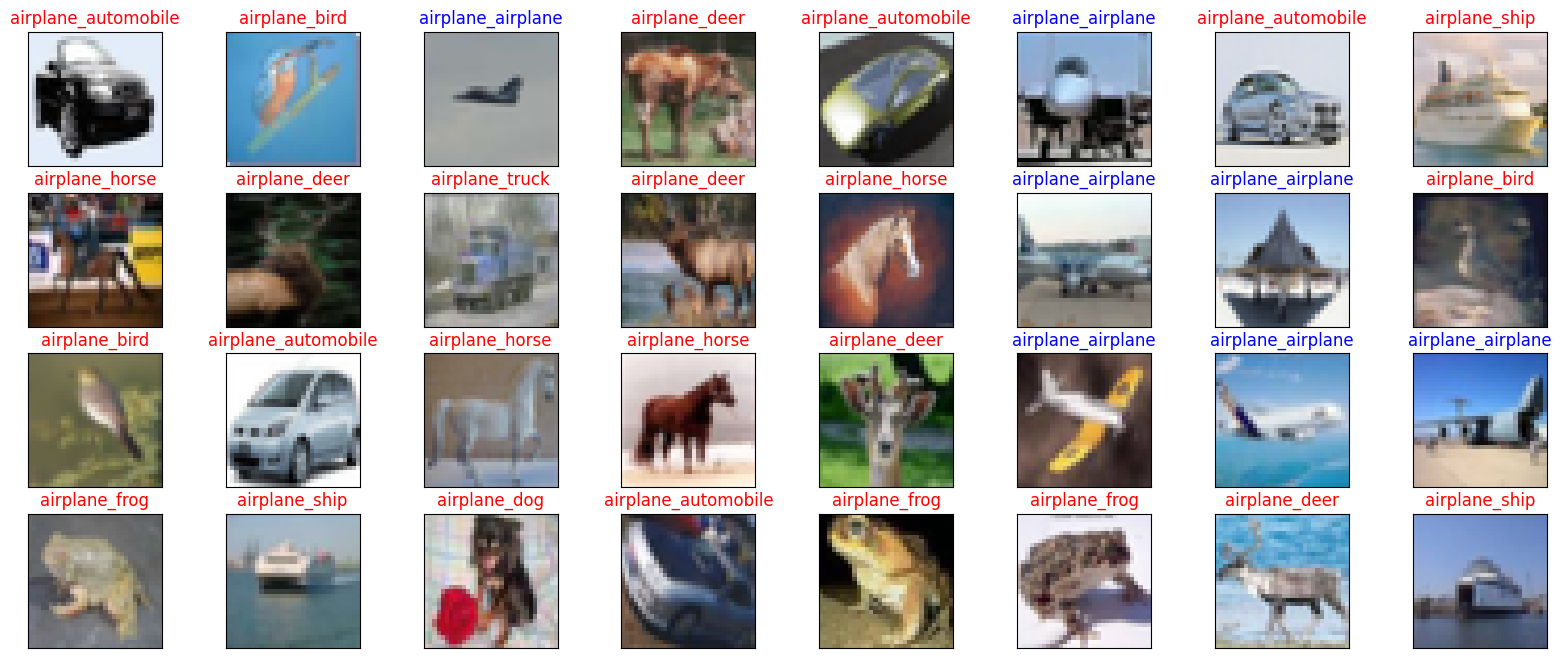

In [16]:
import numpy as np

label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(20,8))

for i, idx in enumerate(np.random.choice(test_images.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4,8, i+1 , xticks=[], yticks=[])
    
    
    # 배포된 모델 사용 
    output = predictor.predict(test_images[i].reshape(1, 32, 32, 3))
    
    pred_idx = np.argmax(output)
    true_idx = np.argmax(test_labels[idx])
    
    ax.imshow(np.squeeze(test_images[idx]))
    
    # 이미지 출력 - 예측한 결과가 정답이면 파란색, 아니면 빨간색으로 표시
    ax.set_title("{}_{}".format(label[pred_idx], label[true_idx]), color='blue' if pred_idx == true_idx else 'red')

# 2. 인터넷 영화 리뷰에 대한 감정 분류 학습을 Keras를 사용한 RNN(Recurrent Neural Network)으로 구현

순환 신경망 RNN(Recurrent Neural Network)은 입력과 출력을 시퀀스 단위로 처리하는 시퀀스(Sequence) 모델입니다. 자연어 처리에 대표적으로 사용되는 인공 신경망이 바로 RNN입니다. 신경망들은 전부 은닉층에서 활성화 함수를 지난 값은 오직 출력층 방향으로만 향했습니다. 이와 같은 신경망들을 피드 포워드 신경망(Feed Forward Neural Network)이라고 합니다. 그런데 그렇지 않은 신경망들이 있습니다. RNN(Recurrent Neural Network) 또한 그 중 하나입니다. RNN은 은닉층의 노드에서 활성화 함수를 통해 나온 결과값을 출력층 방향으로도 보내면서, 다시 은닉층 노드의 다음 계산의 입력으로 보내는 특징을 갖고 있습니다.

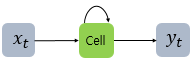

시퀀스 데이터(Sequential data)는 ‘어떤 순서를 가진 데이터’로 순서가 변경될 경우 데이터의 특성을 잃어버리는 데이터를 말합니다.   
예를 들어 "I like coffee."라는 문장은 이해할 수 있지만 "Like coffee I"라는 문장은 이해할 수 없습니다. 문장 뿐만 아니라 주가, DNA 염기서열, 날씨와 같은 시계열 데이터(time series data)는 모두 순차 데이터에 해당합니다.  

시퀀스 데이터를 분석하기 위한 모델은 과거 정보를 기억하는 기능이 필요합니다. 과거 정보를 기억하기 위해 사용하는 대표적인 방법은 이전에 사용한 데이터를 재사용하는 방법이 있습니다.  
데이터를 재사용하기 위해서는 신경망 층에 순환될 부분이 필요합니다. 이런 알고리즘을 우리는 순환 신경망이라고 부른다.

## 순환 신경망(RNN) 구조
x는 입력층의 입력 벡터, y는 출력층의 출력 벡터입니다. RNN에서 은닉층에서 활성화 함수를 통해 결과를 내보내는 역할을 하는 노드를 셀(cell)이라고 합니다. 이 셀은 이전의 값을 기억하려고 하는 일종의 메모리 역할을 수행하므로 이를 메모리 셀 또는 RNN 셀이라고 표현합니다. 은닉층의 메모리 셀은 각각의 시점(time step)에서 바로 이전 시점에서의 은닉층의 메모리 셀에서 나온 값을 자신의 입력으로 사용하는 재귀적 활동을 하고 있습니다. 

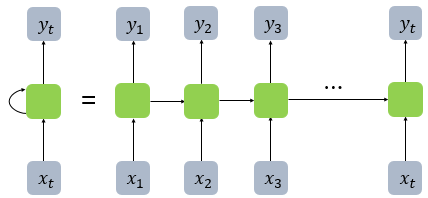

현재 시점을 변수 t로 표현하겠습니다. 이는 현재 시점 t에서의 메모리 셀이 갖고있는 값은 과거의 메모리 셀들의 값에 영향을 받은 것임을 의미합니다. 메모리 셀이 출력층 방향 또는 다음 시점인 t+1의 자신에게 보내는 값을 은닉 상태(Hidden state)라고 합니다. 다시 말해 t 시점의 메모리 셀은 t-1 시점의 메모리 셀이 보낸 은닉 상태값을 t 시점의 은닉 상태 계산을 위한 입력값으로 사용합니다.


### 기울기 소실 문제
기울기 소실 문제는 입력층에 가까운 층의 기울기가 0에 가깝게 수렴하는 현상을 말합니다. 기울기가 0이 되면 특성 값도 0이 되고 유의미한 모델을 만들 수 없게 됩니다. 이런 현상은 왜 일어날까요?

우리는 뛰어난 신경망 모델을 만들기 위해 여러 개의 층을 추가합니다. 이 때 층이 많아 질수록 그에 따른 가중치도 자연스럽게 늘어납니다.  
일반적으로 인공신경망에서 가중치를 업데이트 할 때 오류 역전파 알고리즘(Back propagation algorithm)을 사용합니다.  
오류 역전파 알고리즘은 데이터가 입력층에서 출력층으로 가는 것과 반대로 출력층에서 입력층 방향으로 가중치를 업데이트 합니다. 많은 층을 지날 경우 소수점의 가중치를 계속 곱하다 보면 값은 0에 수렵하게 될 것입니다.

즉, 여러 RNN 층을 추가시킨 모델을 이용하여 시퀀스 데이터를 처리할 수 있으나, RNN 층이 많아 질수록 기울기 소실 문제가 나타나기 때문입니다.
입력 데이터가 커지면, 학습 능력이 저하된다는 점입니다. 데이터의 뒤쪽으로 갈수록, 앞쪽의 입력 데이터를 잊게 됩니다.  
입력 데이터와 출력 데이터 사이의 길이가 멀어질수록 연관 관계가 줄어듭니다. 이를 장기 의존성(Long-Term Dependency)문제라고도
합니다.

## LSTM(Long-Short Term Memory)
LSTM은 RNN이 오래된 것을 기억하지 못하는, 기울기 소실 문제를 해결하기 위해 만들어졌습니다. 또한 빠른 학습 속도의 장점이 있습니다.  
LSTM 알고리즘은 기억할 것과 잊을 것을 선택해 중요한 정보만 기억하는 것이 핵심입니다. 

LSTM은 은닉층의 메모리 셀에 **입력 게이트, 망각 게이트, 출력 게이트**를 추가하여 불필요한 기억을 지우고, 기억해야할 것들을 정합니다. 
LSTM은 은닉 상태(hidden state)를 계산하는 식이 전통적인 RNN보다 조금 더 복잡해졌으며 **셀 상태(cell state)**라는 값을 추가하였습니다. 

이러한 셀 상태(Cell state)가 함께 다음 레이어로 전달되면서, 기존의 상태를 보존하여 **장기의존성 문제를 해결**합니다.

## GRU(Gated Recurrent Uint)
GRU는 LSTM의 장기 의존성 문제에 대한 해결책을 유지하면서, 은닉 상태(Hidden state)를 업데이트하는 계산을 줄였습니다. 다시 말해서, GRU는 성능은 LSTM과 유사하면서 복잡했던 LSTM의 구조를 간단하게 만들었습니다. 

LSTM에서는 출력, 입력, 삭제 게이트라는 3개의 게이트가 존재했습니다. 반면, GRU에서는 **업데이트 게이트**와 **리셋 게이트** 두 가지 게이트만이 존재합니다.  
GRU는 LSTM보다 학습 속도가 빠르다고 알려져있지만 여러 평가에서 GRU는 LSTM과 비슷한 성능을 보인다고 알려져 있습니다.  

IMDB 데이터 세트를 이용하여 영화 리뷰를 긍정적 또는 부정적으로 분류하기 위해 RNN, LSTM, GRU를 기반으로 처리하는 예제입니다.

## 2.1 GRU로 IMDB 리뷰 감성 분류하기

IMDB 영화 리뷰 사이트에서 리뷰 데이터를 불러옵니다.
긍정 리뷰인지, 부정 리뷰인지 분류를 하려고 합니다.

### 2.1.1 준비

In [17]:
import re
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

### 2.1.2 데이터 확인

In [18]:
vocab_size = 10000
max_len = 500

# 데이터 로드
(train_text, train_labels), (test_text, test_labels) = imdb.load_data(num_words=vocab_size)

# 훈련, 테스트 데이터의 단어 집합의 크기를 10,000으로 제한하고 리뷰 최대 길이는 500으로 제한하여 패딩 진행
train_text = pad_sequences(train_text, maxlen=max_len)
test_text = pad_sequences(test_text, maxlen=max_len)
print('훈련용 리뷰 개수 : {}'.format(len(train_text)))
print('테스트용 리뷰 개수 : {}'.format(len(test_text)))

num_classes = len(set(train_labels))
print('카테고리 : {}'.format(num_classes))

17464789/17464789 [==============================] - 0s 0us/step
훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


### 2.1.3 모델 생성
* EarlyStopping는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면, 정해진 에포크(epoch)가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)하겠다는 의미입니다. 
* ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다. validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다.

In [19]:
embedding_dim = 100
hidden_units = 128

# 모델 구성
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

### 2.1.4 모델 컴파일 및 훈련

In [20]:
# 모델 컴파일 및 훈련
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_text, train_labels, epochs=10, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.5357 - acc: 0.7179
Epoch 1: val_acc improved from -inf to 0.78140, saving model to GRU_model.h5
313/313 [==============================] - 251s 795ms/step - loss: 0.5357 - acc: 0.7179 - val_loss: 0.4628 - val_acc: 0.7814
Epoch 2/10


/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 0.3544 - acc: 0.8545
Epoch 2: val_acc improved from 0.78140 to 0.84260, saving model to GRU_model.h5
313/313 [==============================] - 247s 790ms/step - loss: 0.3544 - acc: 0.8545 - val_loss: 0.3689 - val_acc: 0.8426
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.2883 - acc: 0.8871
Epoch 3: val_acc improved from 0.84260 to 0.86660, saving model to GRU_model.h5
313/313 [==============================] - 247s 789ms/step - loss: 0.2883 - acc: 0.8871 - val_loss: 0.3324 - val_acc: 0.8666
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.2532 - acc: 0.9033
Epoch 4: val_acc did not improve from 0.86660
313/313 [==============================] - 247s 788ms/step - loss: 0.2532 - acc: 0.9033 - val_loss: 0.3723 - val_acc: 0.8388
Epoch 5/10
313/313 [==============================] - ETA: 0s - loss: 0.2111 - acc: 0.9189
Epoch 5: val_acc did not improve from 0.86660
313/313 [===========

### 2.1.5 모델 평가

In [21]:
# 모델 정확도 확인
loaded_model = load_model('GRU_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(test_text, test_labels)[1]))

782/782 [==============================] - 123s 157ms/step - loss: 0.3686 - acc: 0.8719

 테스트 정확도: 0.8719


### 2.1.6 모델 예측 - 감정 분석
입력된 문장에 대해서 기본적인 전처리와 정수 인코딩, 패딩을 한 후에 모델의 입력으로 사용하여 긍정 혹은 부정을 예측합니다.

In [22]:
word_to_index = imdb.get_word_index()
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key

1641221/1641221 [==============================] - 0s 0us/step


In [23]:
def sentiment_predict(new_sentence):
    
    # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
    new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()
    encoded = []

    # 띄어쓰기 단위 토큰화 후 정수 인코딩
    for word in new_sentence.split():
        try :
            # 단어 집합의 크기를 10,000으로 제한.
            if word_to_index[word] <= 10000:
                encoded.append(word_to_index[word]+3)
            # 10,000 이상의 숫자는 <unk> 토큰으로 변환.
            else:
                encoded.append(2)
                
        # 단어 집합에 없는 단어는 <unk> 토큰으로 변환.
        except KeyError:
            encoded.append(2)

    pad_sequence = pad_sequences([encoded], maxlen=max_len)
    
    # 예측 점수
    score = float(loaded_model.predict(pad_sequence))

    # 예측 점수가 0.5 이상이면, 긍정 리뷰
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [24]:
# 부정 리류 입력하여 예측 -> 부정 결과 확인
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

sentiment_predict(test_input)

1/1 [==============================] - 0s 398ms/step
72.81% 확률로 부정 리뷰입니다.


In [25]:
# 긍정 리류 입력하여 예측 -> 부정 결과 확인
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. \
Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. \
Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

sentiment_predict(test_input)

1/1 [==============================] - 0s 118ms/step
99.50% 확률로 긍정 리뷰입니다.


## (선택 과제) 2.2 RNN, LSTM, GRU 모델 비교
### 2.2.1 준비
필요한 라이브러리들을 import 합니다.

In [26]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
 
import numpy as np
import matplotlib.pyplot as plt

### 2.2.2 데이터 준비

IMDB 데이터세트에는 인터넷 영화 데이터베이스에서 가져온 50,000개의 영화 리뷰 텍스트가 포함되어 있습니다.  
훈련용 리뷰 25,000개와 테스트용 리뷰 25,000개로 나뉩니다. 훈련 및 테스트 세트는 균형을 이룹니다.  
즉, 동일한 수의 긍정적인 리뷰와 부정적인 리뷰가 포함되어 있습니다.

max_features = 10000
maxlen = 500
batch_size = 128
 
(train_text, train_labels), (test_text, test_labels) = keras.datasets.imdb.load_data(num_words=max_features)

print(len(train_text), '훈련 시퀀스')
print(len(test_text), '테스트 시퀀스')

In [31]:
max_features = 10000
maxlen = 500
batch_size = 128

print('시퀀스 패딩 (samples x time)')

train_text = keras.preprocessing.sequence.pad_sequences(train_text, maxlen=maxlen, padding='post')
test_text = keras.preprocessing.sequence.pad_sequences(test_text, maxlen=maxlen, padding='post')

print('x_train 크기:', train_text.shape)
print('x_test 크기:', test_text.shape)

시퀀스 패딩 (samples x time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


### 2.2.3 모델 생성 및 평가
Keras에는 다음 3가지의 모델이 내장되어 있습니다.

* SimpleRNN
    * 이전 timestep의 출력이 다음 timestep으로 완전히 연결된 모델입니다.
* LSTM(Long Short-Term Memory)
    * 기존의 RNN이 가진 기울기 소실(vanishing gradient), 장기 기억 의존성 등의 문제를 해결하기 위해 나온 모델입니다.
* GRU
    * LSTM을 좀 더 단순화시키고, 보다 적은 데이터로도 학습이 가능한 모델입니다.

### SimpleRNN layer 사용
시퀀스 데이터 처리에 적합하고 맥락의 흐름을 기억할 수 있는 모델로, 문장이 길어질 경우 기울기 소실이 발생합니다.

In [33]:
# RNN 모델 생성

model = models.Sequential(
    [ layers.Embedding(max_features, 100),
      layers.SimpleRNN(32),
      layers.Dense(1, activation='sigmoid')
    ]
)

# 모델 컴파일 및 모델 정보 확인
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1004289 (3.83 MB)
Trainable params: 1004289 (3.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
# 모델 훈련
history = model.fit(train_text, train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 45s 283ms/step - loss: 0.6936 - acc: 0.5049 - val_loss: 0.6938 - val_acc: 0.4938
Epoch 2/10
157/157 [==============================] - 43s 277ms/step - loss: 0.6942 - acc: 0.5028 - val_loss: 0.6936 - val_acc: 0.5062
Epoch 3/10
157/157 [==============================] - 43s 276ms/step - loss: 0.6935 - acc: 0.5041 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 4/10
157/157 [==============================] - 44s 278ms/step - loss: 0.6941 - acc: 0.5020 - val_loss: 0.6946 - val_acc: 0.4946
Epoch 5/10
157/157 [==============================] - 44s 277ms/step - loss: 0.6937 - acc: 0.5025 - val_loss: 0.6927 - val_acc: 0.5146
Epoch 6/10
157/157 [==============================] - 43s 277ms/step - loss: 0.6935 - acc: 0.4987 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 7/10
157/157 [==============================] - 43s 275ms/step - loss: 0.6934 - acc: 0.5064 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 8/10
157/157 [==============================] - 4

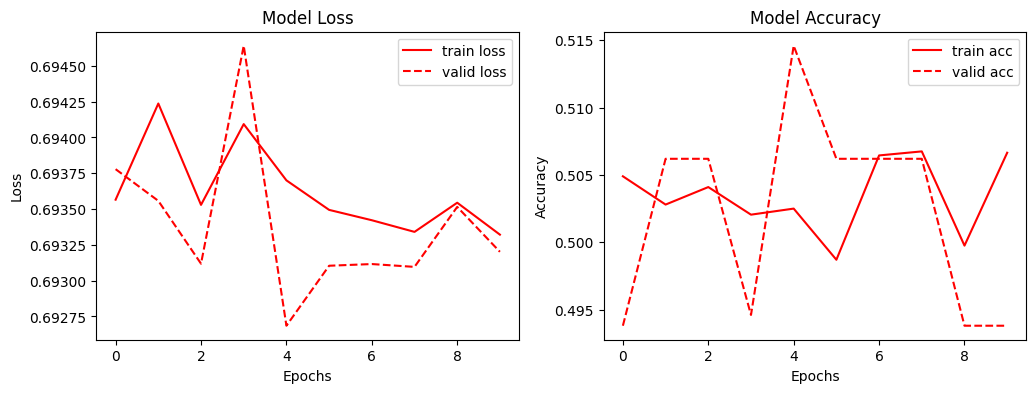

In [35]:
# 훈련 결과 손실 및 정확도 확인
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], 'r-', label='train loss')
plt.plot(history.history['val_loss'], 'r--', label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
 
plt.subplot(122)
plt.plot(history.history['acc'], 'r-', label='train acc')
plt.plot(history.history['val_acc'], 'r--', label='valid acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

In [36]:
# 모델 테스트 결과 확인
model.evaluate(test_text, test_labels)

782/782 [==============================] - 34s 43ms/step - loss: 0.6932 - acc: 0.5000


[0.6931542158126831, 0.5]

### LSTM layer 사용

In [37]:
# LSTM 모델 생성
model = models.Sequential(
    [layers.Embedding(max_features, 100),
     layers.LSTM(32),
     layers.Dense(1, activation='sigmoid')]
)

# 모델 컴파일 및 모델 정보 확인
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1017057 (3.88 MB)
Trainable params: 1017057 (3.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
# 모델 훈련
history = model.fit(train_text, train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 99s 622ms/step - loss: 0.6934 - acc: 0.5008 - val_loss: 0.6934 - val_acc: 0.4938
Epoch 2/10
157/157 [==============================] - 97s 617ms/step - loss: 0.6934 - acc: 0.4924 - val_loss: 0.6932 - val_acc: 0.4938
Epoch 3/10
157/157 [==============================] - 93s 590ms/step - loss: 0.6933 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.4938
Epoch 4/10
157/157 [==============================] - 97s 621ms/step - loss: 0.6933 - acc: 0.4988 - val_loss: 0.6937 - val_acc: 0.4938
Epoch 5/10
157/157 [==============================] - 98s 623ms/step - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 6/10
157/157 [==============================] - 93s 596ms/step - loss: 0.6932 - acc: 0.4992 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 7/10
157/157 [==============================] - 97s 620ms/step - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 8/10
157/157 [==============================] - 9

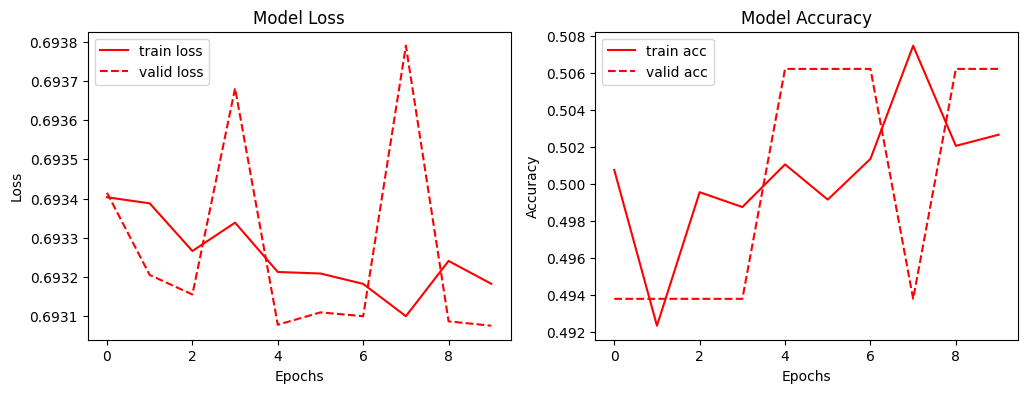

In [39]:
# 훈련 결과 손실 및 정확도 확인
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], 'r-', label='train loss')
plt.plot(history.history['val_loss'], 'r--', label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
 
plt.subplot(122)
plt.plot(history.history['acc'], 'r-', label='train acc')
plt.plot(history.history['val_acc'], 'r--', label='valid acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

In [40]:
# 모델 평가
model.evaluate(test_text, test_labels)

782/782 [==============================] - 49s 63ms/step - loss: 0.6932 - acc: 0.5000


[0.6931894421577454, 0.5]

### GRU layer 사용

In [41]:
# GRU 모델 생성
model = models.Sequential(
    [layers.Embedding(max_features, 100),
     layers.GRU(32),
     layers.Dense(1, activation='sigmoid')]
)

# 모델 컴파일 및 모델 정보 확인
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         1000000   
                                                                 
 gru_1 (GRU)                 (None, 32)                12864     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1012897 (3.86 MB)
Trainable params: 1012897 (3.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# 모델 훈련
history = model.fit(train_text, train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 99s 616ms/step - loss: 0.6935 - acc: 0.4994 - val_loss: 0.6935 - val_acc: 0.4938
Epoch 2/10
157/157 [==============================] - 92s 588ms/step - loss: 0.6933 - acc: 0.5015 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 3/10
157/157 [==============================] - 97s 618ms/step - loss: 0.6933 - acc: 0.4983 - val_loss: 0.6936 - val_acc: 0.4938
Epoch 4/10
157/157 [==============================] - 93s 591ms/step - loss: 0.6932 - acc: 0.5045 - val_loss: 0.6933 - val_acc: 0.4938
Epoch 5/10
157/157 [==============================] - 97s 616ms/step - loss: 0.6933 - acc: 0.4972 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 6/10
157/157 [==============================] - 93s 590ms/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6934 - val_acc: 0.4938
Epoch 7/10
157/157 [==============================] - 93s 590ms/step - loss: 0.6931 - acc: 0.5058 - val_loss: 0.6939 - val_acc: 0.4938
Epoch 8/10
157/157 [==============================] - 9

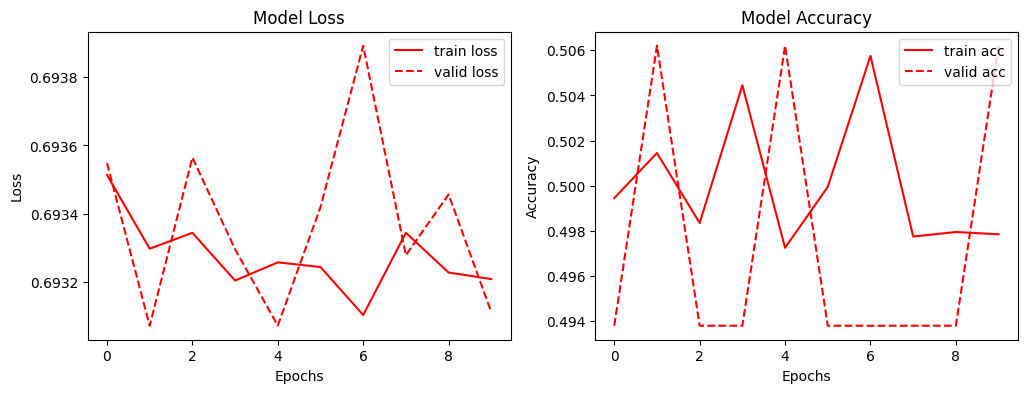

In [43]:
# 훈련 결과 손실 및 정확도 확인
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], 'r-', label='train loss')
plt.plot(history.history['val_loss'], 'r--', label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
 
plt.subplot(122)
plt.plot(history.history['acc'], 'r-', label='train acc')
plt.plot(history.history['val_acc'], 'r--', label='valid acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

In [44]:
# 모델 평가
model.evaluate(test_text, test_labels)

782/782 [==============================] - 72s 92ms/step - loss: 0.6931 - acc: 0.5000


[0.6931498646736145, 0.5]